In [2]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [3]:
data_dir = '../../../data/' # 경로는 상황에 맞춰서 수정해주세요!
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
sub_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

# train_df와 test_df의 기본정보

In [32]:
print(f"""--- Train_df INFORMATIONS ---
shape            : {train_df.shape}
Columns          : {train_df.columns.tolist()}
userID           : {train_df.userID.nunique()}
assessmentItemID : {train_df.assessmentItemID.nunique()}
testID           : {train_df.testId.nunique()}
mean answer rate : {train_df.answerCode.sum() / train_df.shape[0] * 100:.2f}%
KnowledgeTag     : {train_df.KnowledgeTag.nunique()}
{'-'*26}""")

--- Train_df INFORMATIONS ---
shape            : (2266586, 6)
Columns          : ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag']
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


In [33]:
print(f"""--- Test_df INFORMATIONS ---
shape                    : {test_df.shape}
Columns                  : {test_df.columns.tolist()}
userID(사용자ID)           : {test_df.userID.nunique()}
assessmentItemID(문항ID)  : {test_df.assessmentItemID.nunique()}
testID(시험지ID)           : {test_df.testId.nunique()}
mean answer rate(정답률)   : {test_df.answerCode.mean():.2%}
KnowledgeTag(문제 유형)     : {test_df.KnowledgeTag.nunique()}
{'-'*26}""")

--- Test_df INFORMATIONS ---
shape                    : (260114, 6)
Columns                  : ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag']
userID(사용자ID)           : 744
assessmentItemID(문항ID)  : 9454
testID(시험지ID)           : 1537
mean answer rate(정답률)   : 65.22%
KnowledgeTag(문제 유형)     : 912
--------------------------


# test_df의 answerCode가 -1인 데이터를 제거 한 후의 평균 정답률
test_df에는 'answerCode'가 -1인 데이터(744개)가 섞여있다.</br>
-> 'answerCode'가 -1인 데이터를 제외하고 난 뒤의 평균 정답률</br>
65.22% -> 65.69% : 큰 차이는 없다.</br>

In [37]:
test_df[test_df['answerCode']!=-1]['answerCode'].mean()

0.6569109765971393

# train의 데이터 시작, 마지막 시각
시작 시각  : 2019-12-31 15:08:01</br>
마지막 시각 : 2020-12-29 16:46:21

In [42]:
train_df['Timestamp'].sort_values()

555508    2019-12-31 15:08:01
555509    2019-12-31 15:08:21
555510    2019-12-31 15:08:55
555511    2019-12-31 15:09:13
555512    2019-12-31 15:09:29
                 ...         
420389    2020-12-29 16:46:08
420390    2020-12-29 16:46:13
420391    2020-12-29 16:46:15
420392    2020-12-29 16:46:18
420393    2020-12-29 16:46:21
Name: Timestamp, Length: 2266586, dtype: object

# assessmentItemID의 1,3번째 값엔 0 외엔 없을까?
assessmentItemID의 형식은 'A060001001'와 같다.
그 중 1, 3번쨰 값은 모두 0이다.

In [69]:
print(train_df['assessmentItemID'].str[1].unique())
print(test_df['assessmentItemID'].str[1].unique())

['0']
['0']


In [70]:
print(train_df['assessmentItemID'].str[3].unique())
print(test_df['assessmentItemID'].str[3].unique())

['0']
['0']


In [64]:
print(train_df['assessmentItemID'])

0          A060001001
1          A060001002
2          A060001003
3          A060001004
4          A060001005
              ...    
2266581    A030071005
2266582    A040165001
2266583    A040165002
2266584    A040165003
2266585    A040165004
Name: assessmentItemID, Length: 2266586, dtype: object


# assessmentItemID의 값과 testID의 값은 모두 같을까?
-> 모두 같다.

In [74]:
train_df[train_df['assessmentItemID'].str[1:7] != (train_df['testId'].str[1:4]+train_df['testId'].str[-3:])]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag


In [75]:
test_df[test_df['assessmentItemID'].str[1:7] != (test_df['testId'].str[1:4]+test_df['testId'].str[-3:])]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag


# 하루하루 몇문제를 풀었는지?
-> 주말에는 확실히 문제 푼 횟수가 적은 것을 확인할 수 있다.</br>
-> 3월부터 10월말까지 증가하는 경향을 보인다. -> 매년 경향인지, 그 해 만의 경향인지 알수 없음</br>
-> 10월 27일 부터는 급격하게 푼 횟수가 줄어들었다.(1/4)</br>

<AxesSubplot: xlabel='date'>

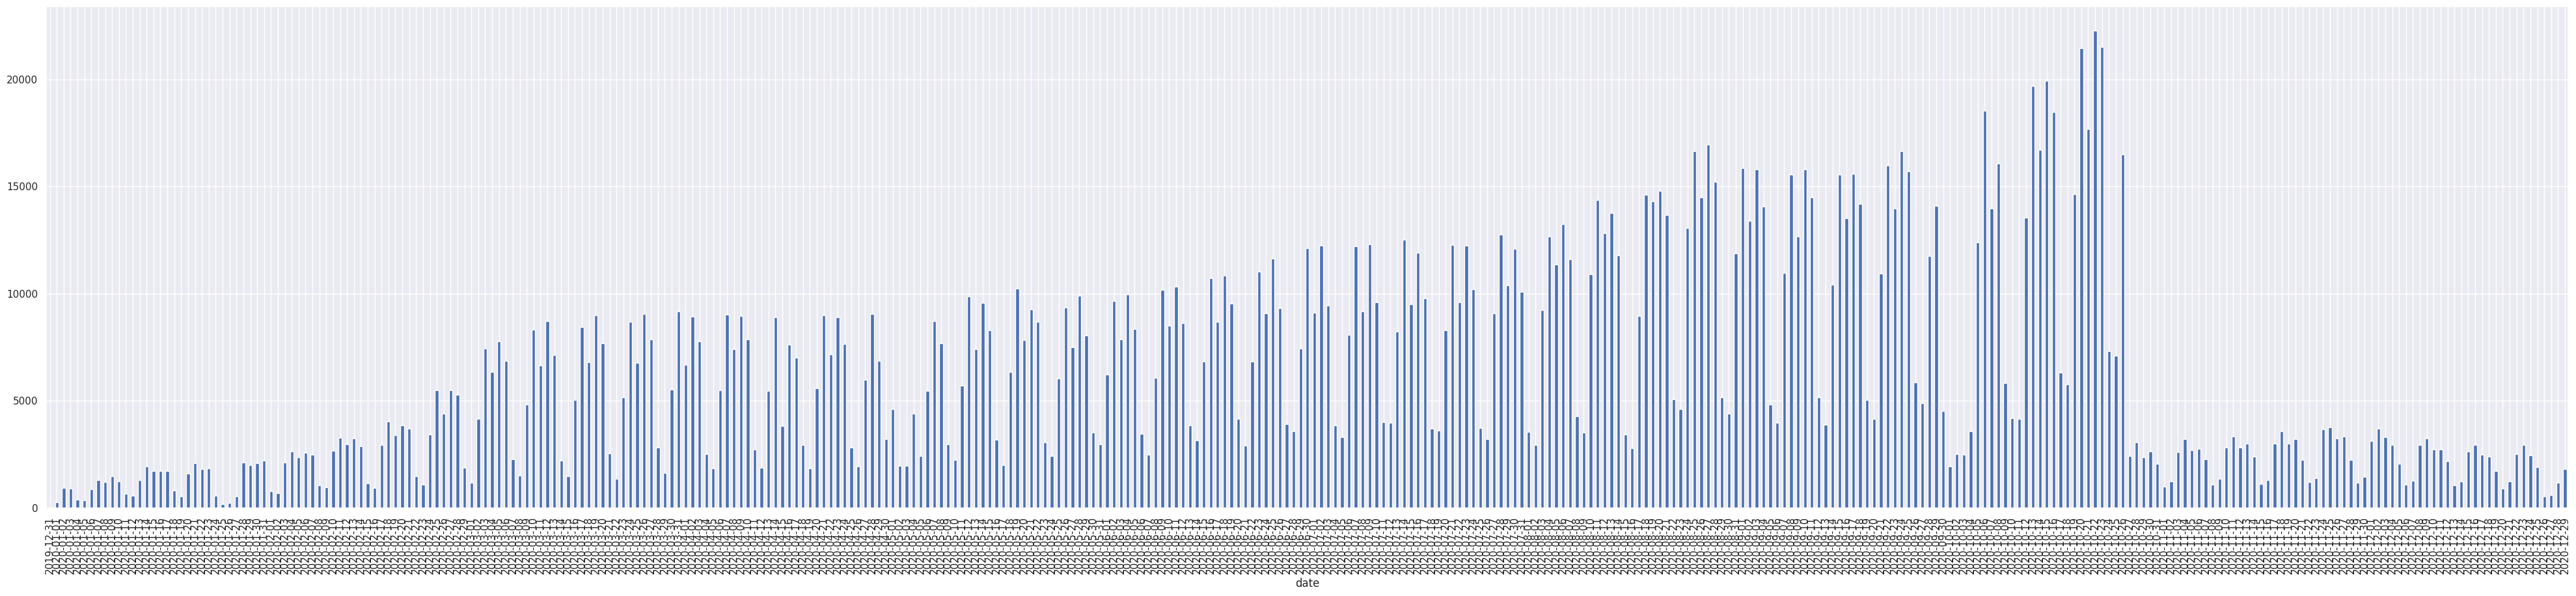

In [21]:
time_df = train_df.copy()
# time_df['date'] = time_df['Timestamp'].astype("datetime64").dt.date
time_df['date'] = pd.to_datetime(time_df['Timestamp']).dt.date
df_gb = time_df.groupby(['date']).size()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

In [139]:
# time_df.sort_values(by='date').groupby('date')['answerCode'].count()

date
2019-12-31      19
2020-01-01     266
2020-01-02     946
2020-01-03     919
2020-01-04     402
              ... 
2020-12-25    1916
2020-12-26     555
2020-12-27     607
2020-12-28    1174
2020-12-29    1835
Name: answerCode, Length: 365, dtype: int64

In [106]:
# train_df['Timestamp'] = train_df['Timestamp'].astype("datetime64")

<AxesSubplot: xlabel='date'>

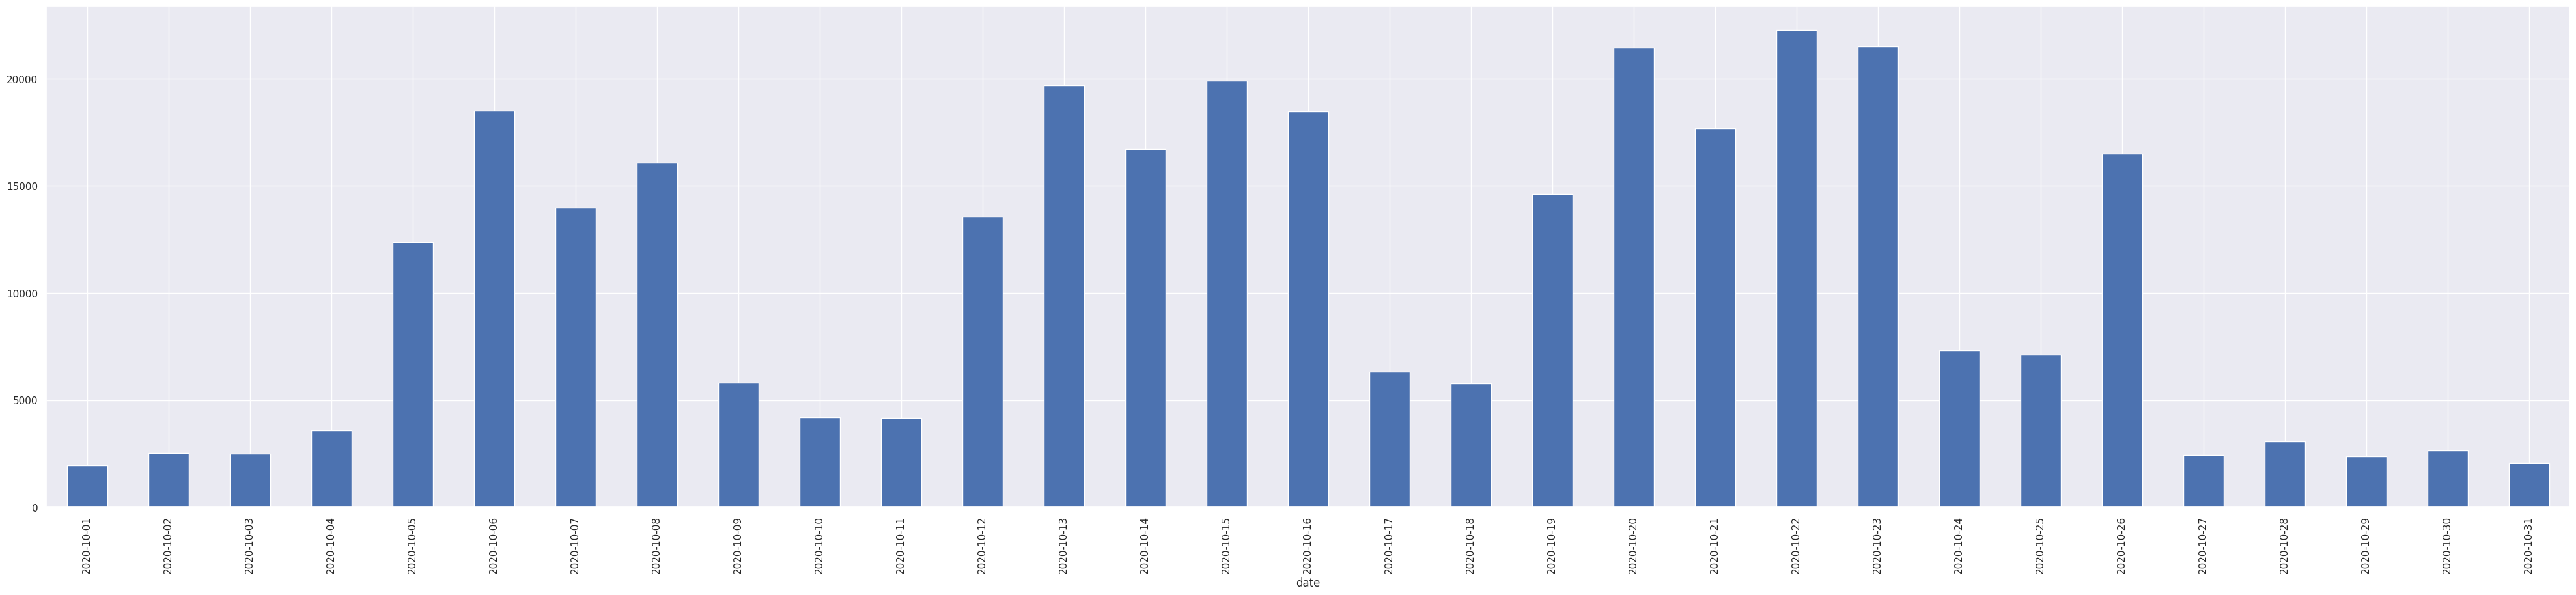

In [20]:
#10월달 날짜 별 푼 횟수
june_df = time_df[time_df['date'].astype("datetime64").dt.month==10]
df_gb = june_df.groupby(['date']).size()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

# 날짜별 정답률은 어떻게 될까?
-> 10월 27일 이후부턴 정답률이 낮아짐을 알 수 있다.

<AxesSubplot: xlabel='date'>

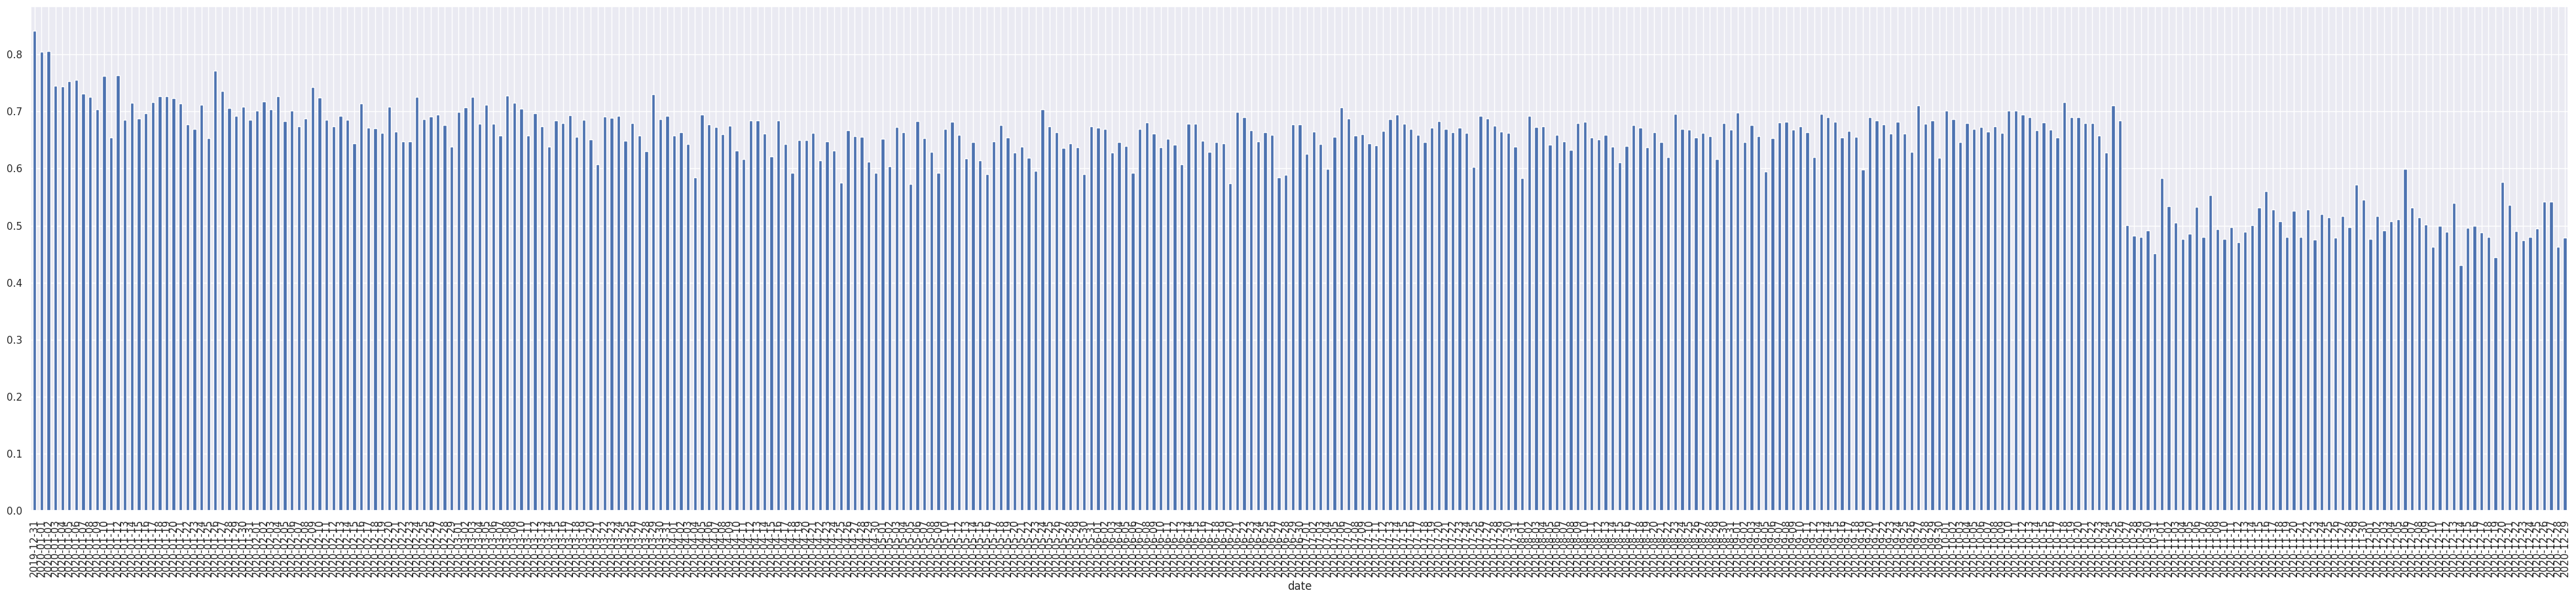

In [19]:
time_df = train_df.copy()
time_df['date'] = pd.to_datetime(time_df['Timestamp']).dt.date
# time_df['date'] = time_df['Timestamp'].astype("datetime64").dt.date
df_gb = time_df.groupby(['date'])['answerCode'].mean()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

# 요일 별 문제 푼 횟수와 평균 정답률


<AxesSubplot: xlabel='date'>

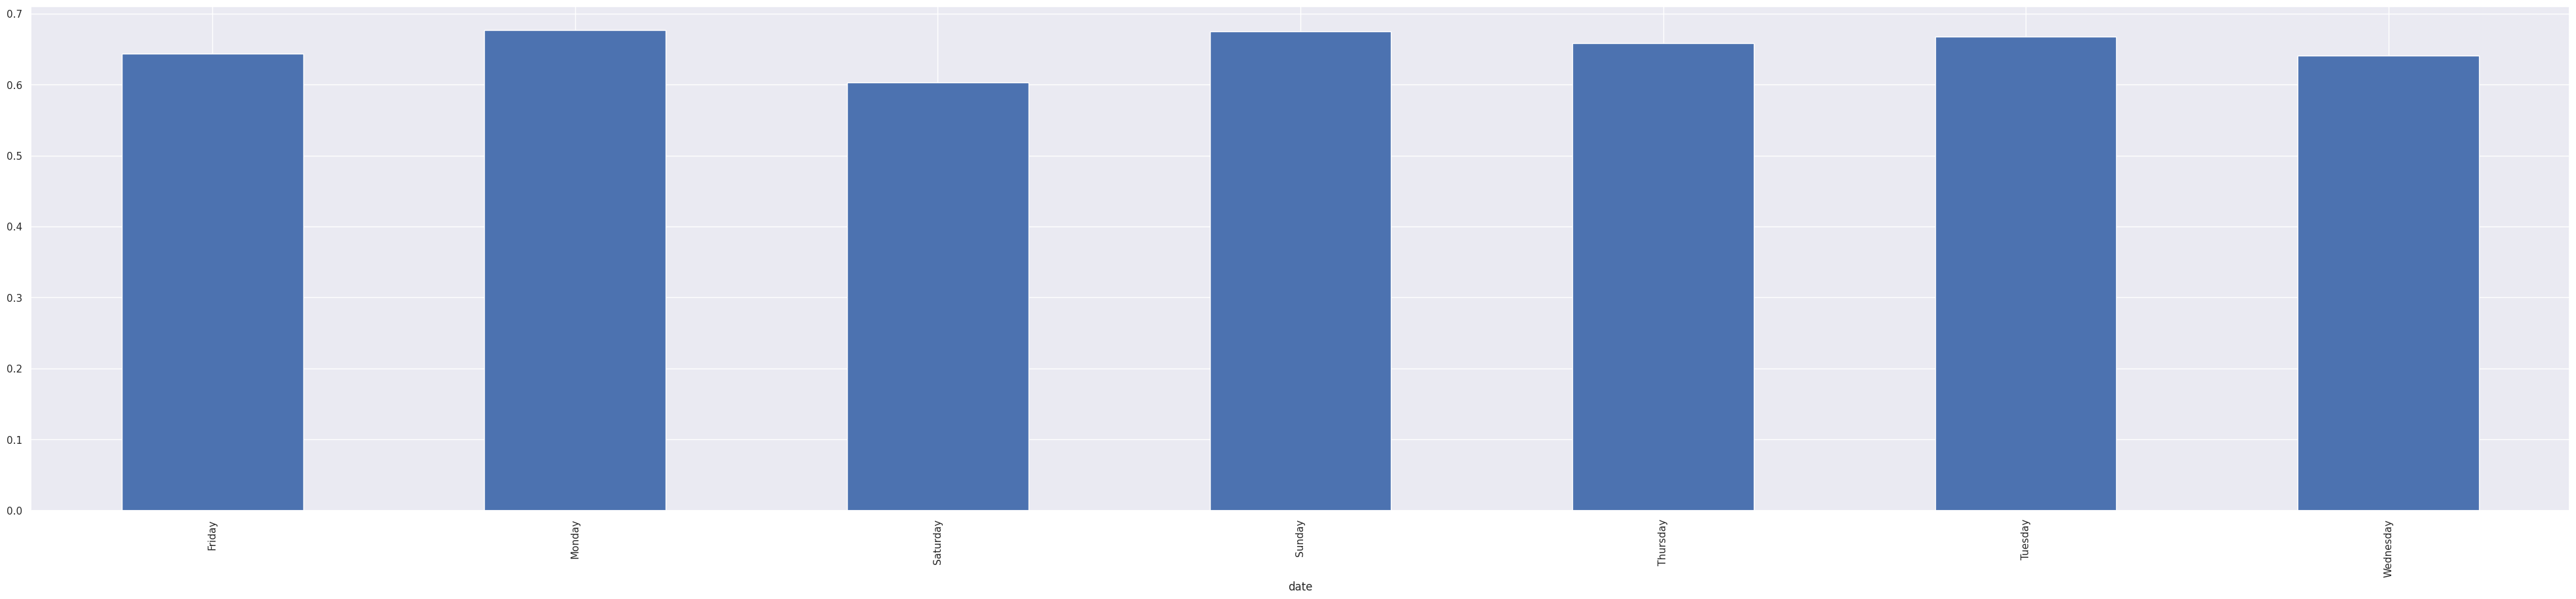

In [23]:
time_df = train_df.copy()
time_df['date'] = pd.to_datetime(time_df['Timestamp']).dt.day_name()
# time_df['date'] = time_df['Timestamp'].astype("datetime64").dt.date
df_gb = time_df.groupby(['date'])['answerCode'].mean()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

In [25]:
df_gb.describe

<bound method NDFrame.describe of date
Friday       0.643362
Monday       0.676518
Saturday     0.603206
Sunday       0.675257
Thursday     0.658466
Tuesday      0.667046
Wednesday    0.641011
Name: answerCode, dtype: float64>

<AxesSubplot: xlabel='date'>

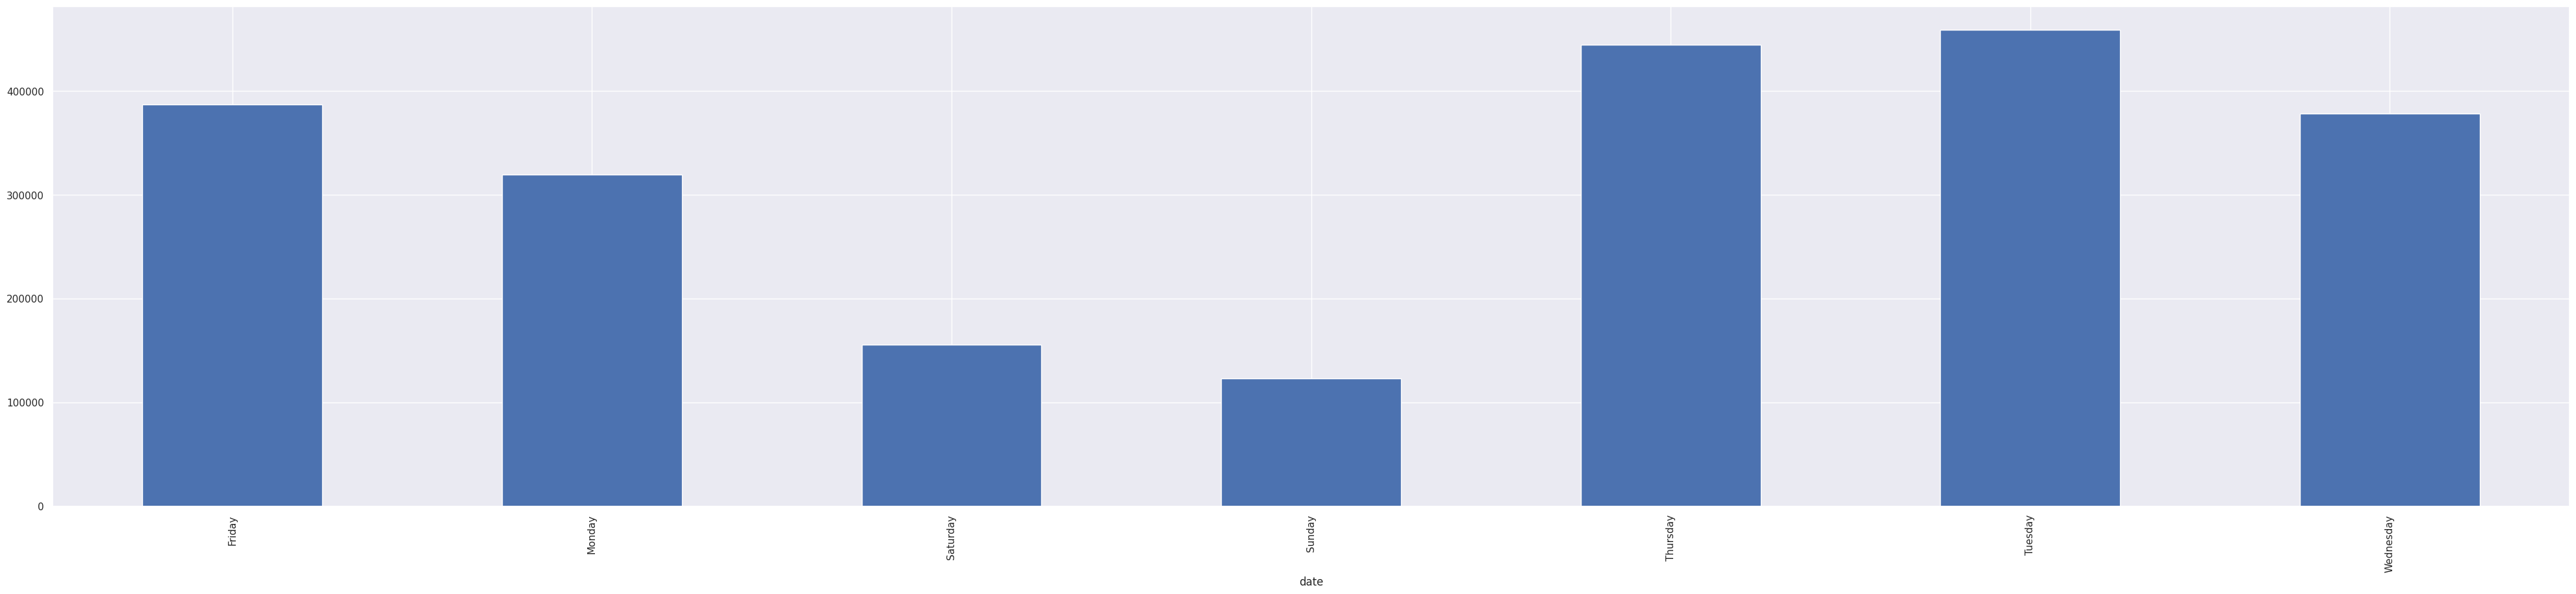

In [29]:
time_df = train_df.copy()
time_df['date'] = pd.to_datetime(time_df['Timestamp']).dt.day_name()
# time_df['date'] = time_df['Timestamp'].astype("datetime64").dt.date
df_gb = time_df.groupby(['date'])['answerCode'].count()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

In [30]:
df_gb.describe

<bound method NDFrame.describe of date
Friday       387283
Monday       319248
Saturday     155330
Sunday       123156
Thursday     444433
Tuesday      458988
Wednesday    378148
Name: answerCode, dtype: int64>

# test데이터의 예측해야하는 데이터의 날짜 보기
7/2일부터 12/29일까지

/tmp/ipykernel_20840/367652996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['date'] = pd.to_datetime(predict_df['Timestamp']).dt.date


<AxesSubplot: xlabel='date'>

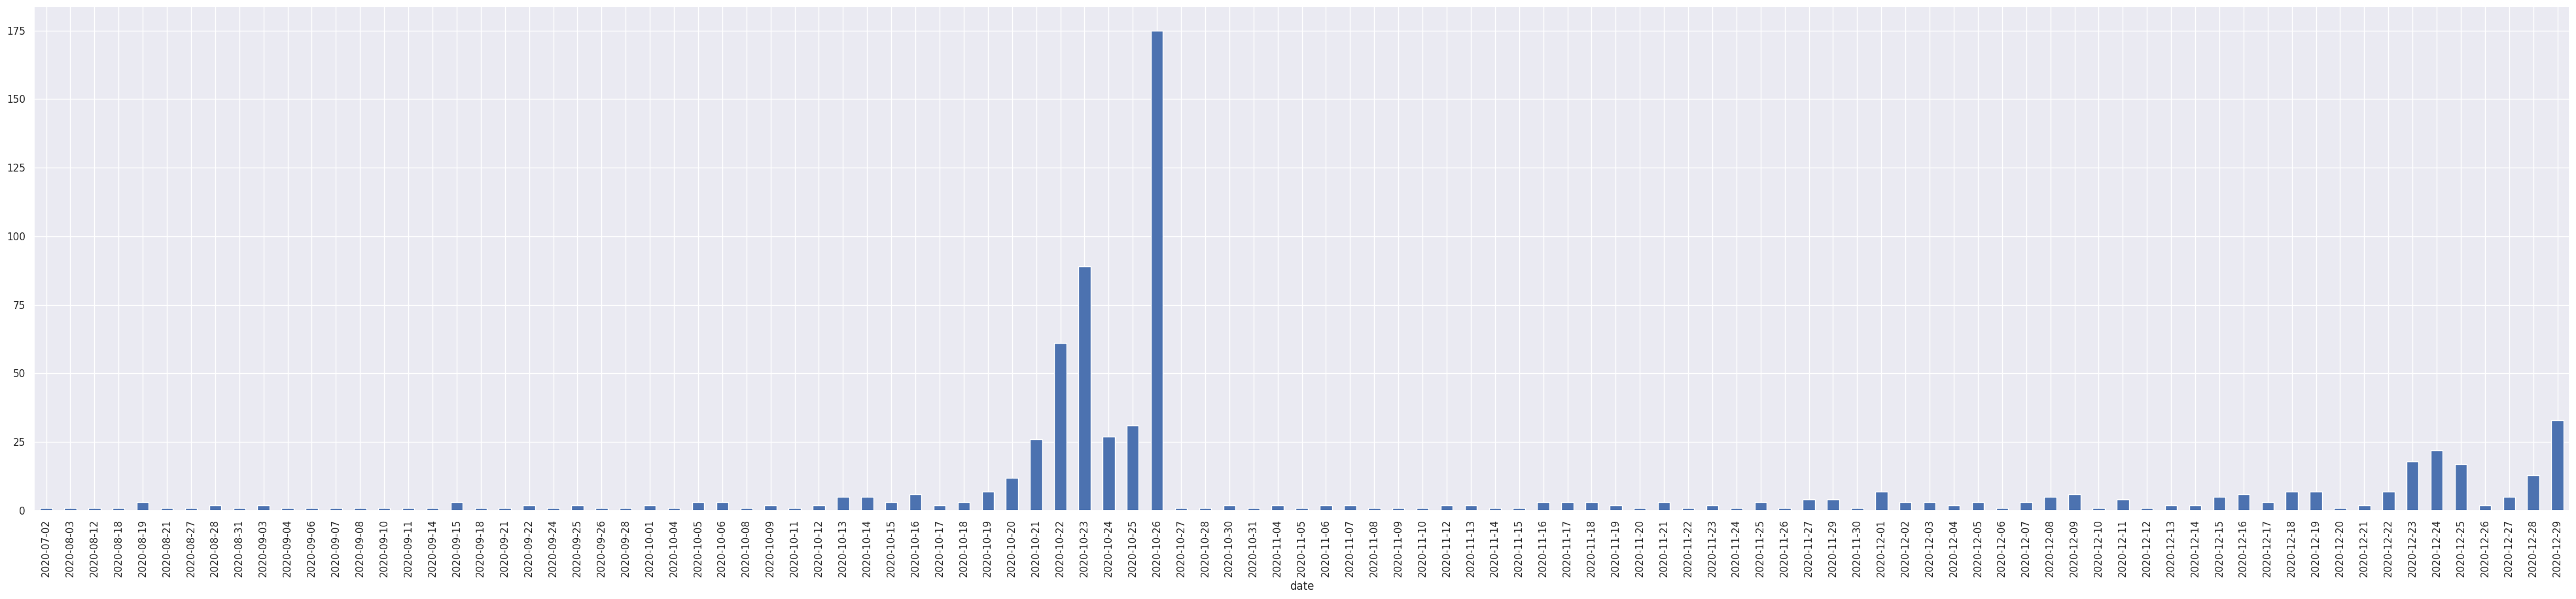

In [32]:
predict_df = test_df[test_df['answerCode']==-1]
predict_df['date'] = pd.to_datetime(predict_df['Timestamp']).dt.date
df_gb = predict_df.groupby(['date']).size()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

# 동일한 문제를 풀었을 때의 회차 별 정답률
한 유저가 동일한 문제를 푼 횟수마다 정답률은 상승할까?</br>
-> 상승 안한다.</br>
-> 1회차 : 0.6542 / 2회차 : 0.6614 / 3회차 : 0.5531</br>

In [66]:
df = train_df.sort_values(by='Timestamp')

In [205]:
#유저, 과제가 등장한 횟수
df['cnt'] = 1
df['cum_cnt'] = df.groupby(['userID', 'assessmentItemID'])['cnt'].cumsum()
df[(df['userID']==354) & (df['assessmentItemID']=='A060001001')] #연산이 잘됐는지 확인
# df.head

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time_shift,cnt,cum_cnt
261618,354,A060001001,A060000001,1,2020-03-03 02:17:56,7224,2019-12-30 00:00:00,1,1
261624,354,A060001001,A060000001,1,2020-03-03 07:23:33,7224,2020-03-03 02:18:47,1,2
261672,354,A060001001,A060000001,1,2020-03-10 09:01:50,7224,2020-03-10 08:17:56,1,3


In [71]:
#회차별 푼 문제 평균 정답률
df.groupby(['cum_cnt'])['answerCode'].mean()

cum_cnt
1    0.654647
2    0.645138
3    0.438849
Name: answerCode, dtype: float64

In [72]:
#회차별 푼 문제 횟수
df.groupby(['cum_cnt'])['answerCode'].count()

cum_cnt
1    2220633
2      45119
3        834
Name: answerCode, dtype: int64

# 동일한 태그를 풀었을 때 회차별 정답률


In [178]:
df = train_df.sort_values(by='Timestamp')
#유저, 과제가 등장한 횟수
df['cnt'] = 1
df['cum_cnt'] = df.groupby(['userID', 'KnowledgeTag'])['cnt'].cumsum()
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,cnt,cum_cnt
555508,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,1,1
555509,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,1,2
555510,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,1,3
555511,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,1,4
555512,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,1,5


<AxesSubplot: xlabel='cum_cnt'>

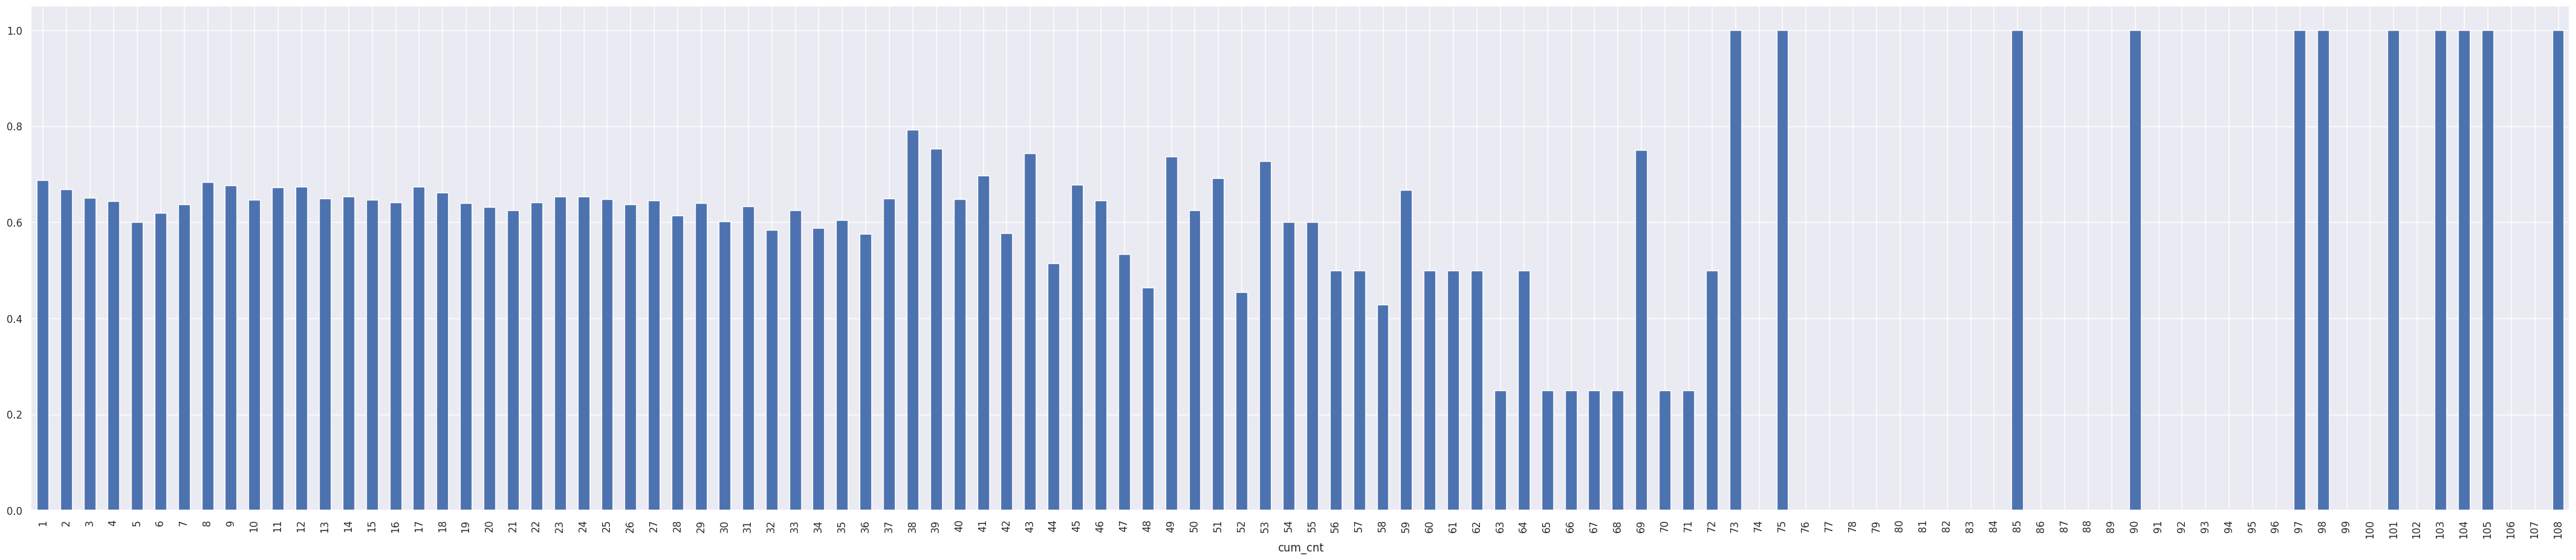

In [179]:
#회차별 푼 문제 평균 정답률
df_gb = df.groupby(['cum_cnt'])['answerCode'].mean()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

<AxesSubplot: xlabel='cum_cnt'>

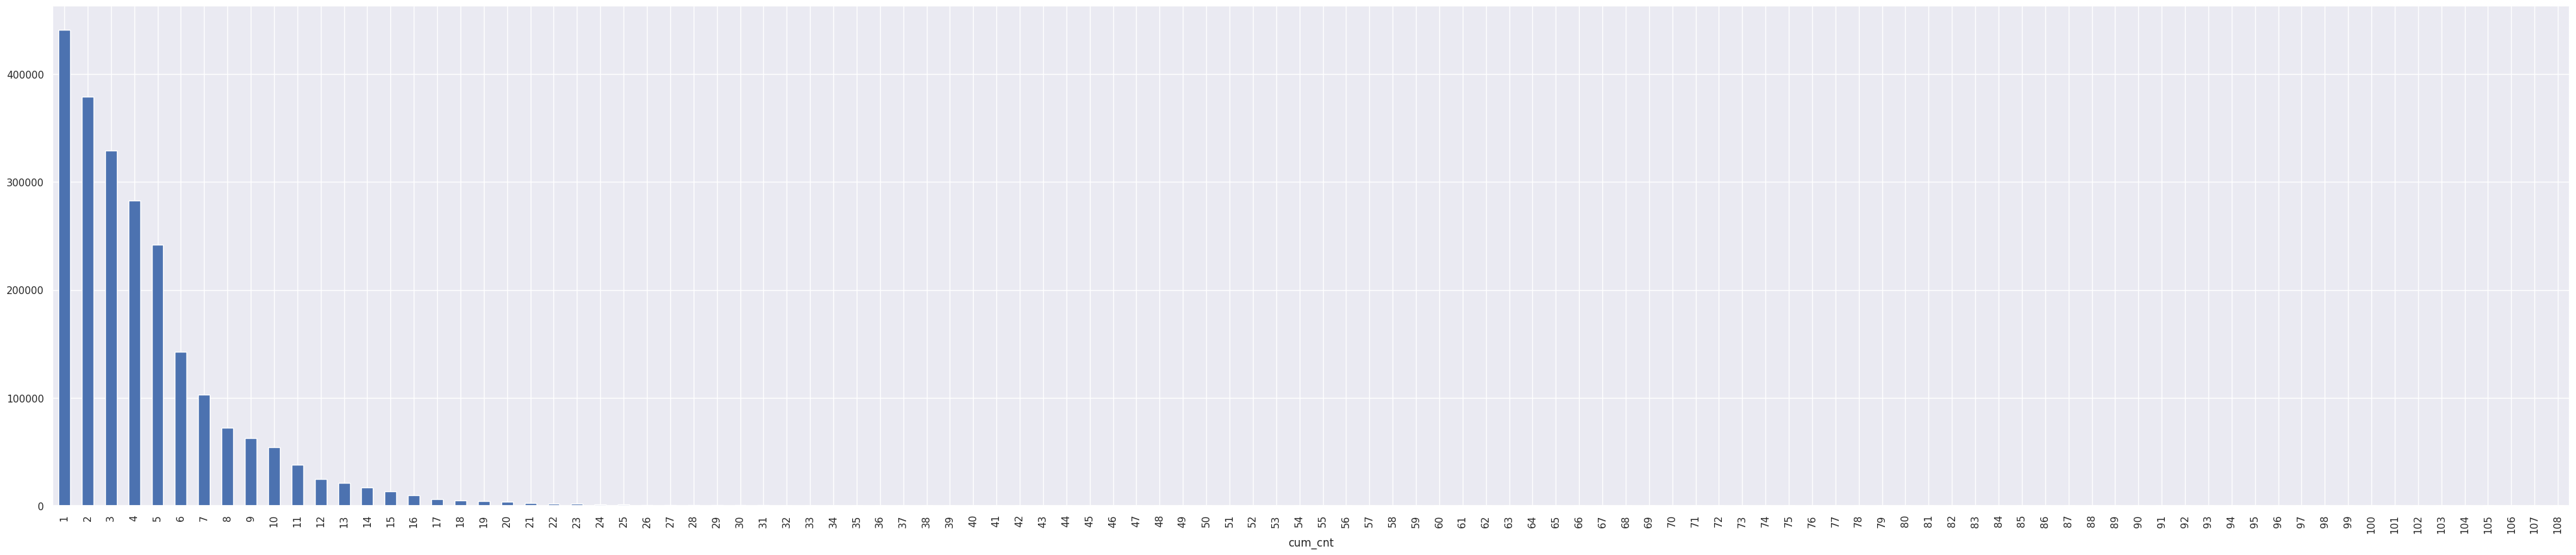

In [180]:
#회차별 푼 문제 횟수
df_gb = df.groupby(['cum_cnt'])['answerCode'].count()
plt.figure(figsize=(50,10))
df_gb.plot(kind = 'bar')

# 동일한 태그를 풀었을 때 회차별 횟수

In [181]:
df[df['cum_cnt'] <= 10]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,cnt,cum_cnt
555508,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,1,1
555509,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,1,2
555510,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,1,3
555511,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,1,4
555512,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,1,5
...,...,...,...,...,...,...,...,...
420389,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,1,1
420390,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,1,2
420391,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,1,6
420392,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,1,9


In [182]:
len(df[df['cum_cnt'] <= 10])/len(df)

0.9296470550863722

# Timestamp가 너무 짧은 경우 정답률
-> 5초 이내 푼 문제는 확실히 정답률이 낮음을 알 수 있다.

In [190]:
spent_df = train_df.sort_values(by='Timestamp')
spent_df['time_shift'] = spent_df.groupby(['userID'])['Timestamp'].shift().fillna('2019-12-30 00:00:00')

In [191]:
spent_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time_shift
555508,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,2019-12-30 00:00:00
555509,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,2019-12-31 15:08:01
555510,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,2019-12-31 15:08:21
555511,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,2019-12-31 15:08:55
555512,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,2019-12-31 15:09:13


In [192]:
# spent_df['spend_time']

KeyError: 'spend_time'

In [193]:
# spent_df['spend_time'] = spent_df.apply(lambda row:row['Timestamp'] - row['spend_time'])
spent_df['Timestamp'] = pd.to_datetime(spent_df['Timestamp'])
spent_df['time_shift'] = pd.to_datetime(spent_df['time_shift'])
spent_df['spend_time'] = spent_df['Timestamp'] - spent_df['time_shift']

In [206]:
spent_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time_shift,spend_time,category_spend_time
555508,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,2019-12-30 00:00:00,1 days 15:08:01,10
555509,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,2019-12-31 15:08:01,0 days 00:00:20,3
555510,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,2019-12-31 15:08:21,0 days 00:00:34,4
555511,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,2019-12-31 15:08:55,0 days 00:00:18,3
555512,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,2019-12-31 15:09:13,0 days 00:00:16,3
...,...,...,...,...,...,...,...,...,...
420389,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,2020-12-29 16:46:06,0 days 00:00:02,0
420390,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,2020-12-29 16:46:08,0 days 00:00:05,1
420391,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,2020-12-29 16:46:13,0 days 00:00:02,0
420392,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,2020-12-29 16:46:15,0 days 00:00:03,1


In [194]:
from datetime import timedelta
def category_spend_time(x:str):
    if x <= timedelta(seconds=2):
        return 0
    elif x <= timedelta(seconds=5):
        return 1
    elif x <= timedelta(seconds=10):
        return 2
    elif x <= timedelta(seconds=30):
        return 3
    elif x <= timedelta(minutes=1):
        return 4
    elif x <= timedelta(minutes=3):
        return 5
    elif x <= timedelta(minutes=10):
        return 6
    elif x <= timedelta(minutes=30):
        return 7
    elif x <= timedelta(hours=1):
        return 8
    elif x <= timedelta(hours=2):
        return 9
    else:
        return 10

In [195]:
spent_df['category_spend_time']= spent_df['spend_time'].apply(category_spend_time)

<AxesSubplot: xlabel='category_spend_time'>

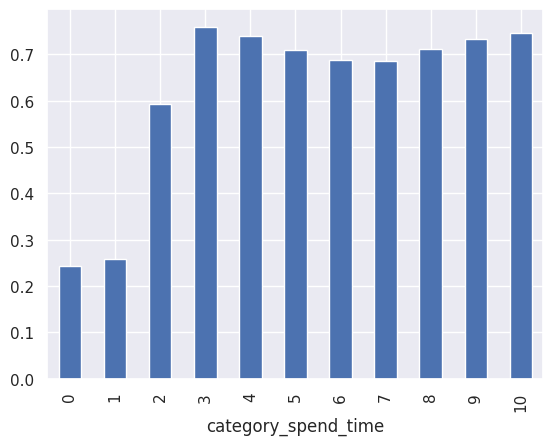

In [196]:
spent_df.groupby(['category_spend_time'])['answerCode'].mean().plot(kind="bar")

<AxesSubplot: xlabel='category_spend_time,category_spend_time'>

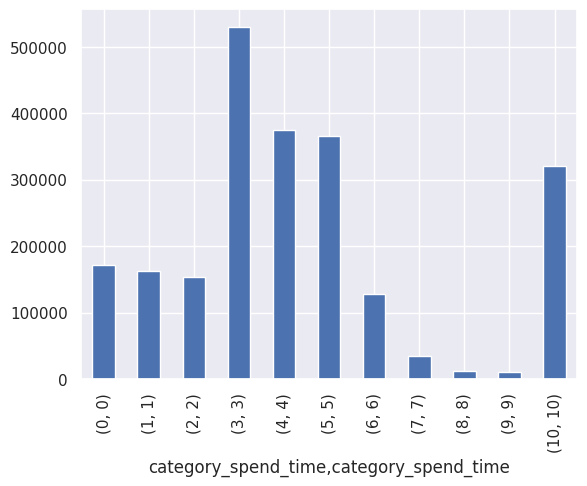

In [204]:
#푸는데 걸린 시간대 별 횟수
spent_df.groupby(['category_spend_time'])['category_spend_time'].value_counts().plot(kind="bar")

In [203]:
spent_df.groupby(['category_spend_time'])['category_spend_time'].value_counts()

category_spend_time
0     171237
1     162894
2     153451
3     530280
4     375271
5     366685
6     128755
7      34124
8      12349
9      10095
10    321445
Name: category_spend_time, dtype: int64